# Regentfund Allocation Strategy

**Proportional Linear Momentum Strategy for Fixed Income Allocation**

This notebook implements two variants:
- **Strategy 1**: Base momentum strategy with cross-asset regime filter and mom240 exit condition
- **Strategy 2**: Strategy 1 + Drawdown Differential Override (asset-level)

---

## Assets
| Code | Description | Benchmark |
|------|-------------|----------|
| H5A4 | High Yield | SPY |
| C5A4 | Corporate (IG) | LQD |
| G502 | Government (Long) | TLT |

In [33]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Imports loaded")

Imports loaded


In [34]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Portfolio Constraints
CONSTRAINTS = {
    'Cash': {'min': 0.05, 'max': 0.10},
    'H5A4': {'min': 0.00, 'max': 0.12},  # HY capped at 12%
    'C5A4': {'min': 0.00, 'max': 0.95},
    'G502': {'min': 0.00, 'max': 0.95}
}

# Strategy 1: Signal Generation Thresholds (per asset)
SIGNAL_THRESHOLDS = {
    'H5A4': -0.03,   # Exit threshold vs SPY
    'C5A4': -0.013,  # Exit threshold vs LQD
    'G502': -0.01    # Exit threshold vs TLT
}

# Defensive Allocation (when no signals active)
DEFENSIVE_ALLOCATION = {'Cash': 0.10, 'H5A4': 0.00, 'C5A4': 0.00, 'G502': 0.90}

print("Configuration loaded")
print(f"\nSignal Thresholds:")
for asset, thresh in SIGNAL_THRESHOLDS.items():
    print(f"  {asset}: {thresh}")
print(f"\nDefensive Allocation: {DEFENSIVE_ALLOCATION}")
print(f"\nNote: Strategy 2 DD override thresholds are set in individual asset analysis files")

Configuration loaded

Signal Thresholds:
  H5A4: -0.03
  C5A4: -0.013
  G502: -0.01

Defensive Allocation: {'Cash': 0.1, 'H5A4': 0.0, 'C5A4': 0.0, 'G502': 0.9}

Note: Strategy 2 DD override thresholds are set in individual asset analysis files


In [35]:
# =============================================================================
# DATA LOADING
# =============================================================================

# Load ETF data for HYG BMOM calculation
etf_data = pd.read_csv('Data Files/Fixed_Income_Data.csv', parse_dates=['Date'], index_col='Date')
etf_data.index = pd.to_datetime(etf_data.index)

# Calculate HYG BMOM (weighted momentum)
hyg = etf_data['HYG']
HYG_BMOM = (0.15 * hyg.pct_change(20) + 0.35 * hyg.pct_change(60) + 
            0.35 * hyg.pct_change(120) + 0.15 * hyg.pct_change(240))

# Load asset-specific data from Excel files
h5a4_data = pd.read_excel('Data Files/Taiya_Shiva_Bond_TAA_Stats_Visual.xlsx', 
                          sheet_name='Strategy_Data', index_col='Date', parse_dates=True)
c5a4_data = pd.read_excel('Data Files/LQD_C5A4_Analysis.xlsx', 
                          sheet_name='Strategy_Data', index_col='Date', parse_dates=True)
g502_data = pd.read_excel('Data Files/TLT_G502_Analysis.xlsx', 
                          sheet_name='Strategy_Data', index_col='Date', parse_dates=True)

# Consolidate into single DataFrame
data = pd.DataFrame()

# Benchmark BMOMs
data['SPY_BMOM'] = h5a4_data['SPY_BMOM']
data['TLT_BMOM'] = g502_data['TLT_BMOM']
data['LQD_BMOM'] = c5a4_data['LQD_BMOM']
data['HYG_BMOM'] = HYG_BMOM

# Asset BMOMs
data['H5A4_BMOM'] = h5a4_data['H5A4_BMOM']
data['C5A4_BMOM'] = c5a4_data['C5A4_BMOM']
data['G502_BMOM'] = g502_data['G502_BMOM']

# Asset Prices
data['H5A4_Price'] = h5a4_data['H5A4_Price']
data['C5A4_Price'] = c5a4_data['C5A4_Price']
data['G502_Price'] = g502_data['G502_Price']

# Mom240 (240-day momentum for exit filter)
data['H5A4_Mom240'] = h5a4_data['H5A4_Mom240']
data['C5A4_Mom240'] = c5a4_data['C5A4_Mom240']
data['G502_Mom240'] = g502_data['G502_Mom240']

# Sort and clean
data = data.sort_index()
data.index = pd.to_datetime(data.index)
data.index.name = 'Date'

# Filter to first common date (no NaN in core columns)
core_cols = ['SPY_BMOM', 'TLT_BMOM', 'LQD_BMOM', 'HYG_BMOM', 
             'H5A4_BMOM', 'C5A4_BMOM', 'G502_BMOM',
             'H5A4_Price', 'C5A4_Price', 'G502_Price', 
             'H5A4_Mom240', 'C5A4_Mom240', 'G502_Mom240']
first_date = data[core_cols].dropna().index.min()
data = data.loc[first_date:].copy()

# Calculate daily returns
data['H5A4_Return'] = data['H5A4_Price'].pct_change()
data['C5A4_Return'] = data['C5A4_Price'].pct_change()
data['G502_Return'] = data['G502_Price'].pct_change()

print(f"Data loaded successfully")
print(f"  Shape: {data.shape}")
print(f"  Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"  Trading days: {len(data):,}")

Data loaded successfully
  Shape: (4439, 16)
  Date range: 2008-03-25 to 2025-11-11
  Trading days: 4,439


---
## Strategy 1: Proportional Linear

**Signal Logic:**
- Entry (signal=1): Asset BMOM > 0
- Exit (signal=0): (Benchmark OR Asset crosses below threshold while BOTH below threshold) AND (Mom240 < 0)
- Hold: Keep previous signal

In [37]:
# =============================================================================
# STRATEGY 1: SIGNAL GENERATION
# =============================================================================

def generate_strategy1_signal(asset_bmom, benchmark_bmom, asset_mom240, threshold):
    """
    Generate Strategy 1 signals for a single asset.
    
    Entry (signal=1): Asset BMOM > 0
    Exit (signal=0):  (Benchmark OR Asset crosses below threshold 
                       while BOTH below threshold) AND (Mom240 < 0)
    Hold: Keep previous signal
    """
    signals = pd.Series(0, index=asset_bmom.index)
    
    for i in range(1, len(asset_bmom)):
        # Current values
        bench_curr = benchmark_bmom.iloc[i]
        asset_curr = asset_bmom.iloc[i]
        mom240_curr = asset_mom240.iloc[i]
        
        # Previous values
        bench_prev = benchmark_bmom.iloc[i-1]
        asset_prev = asset_bmom.iloc[i-1]
        
        # Exit Condition 1: Benchmark crosses below threshold while both below threshold
        cond1 = (bench_prev > threshold) and (bench_curr < threshold) and (asset_curr < threshold)
        
        # Exit Condition 2: Asset crosses below threshold while both below threshold
        cond2 = (asset_prev > threshold) and (bench_curr < threshold) and (asset_curr < threshold)
        
        # Mom240 must be negative for exit
        mom240_negative = mom240_curr < 0
        
        if (cond1 or cond2) and mom240_negative:
            # Exit
            signals.iloc[i] = 0
        elif asset_curr > 0:
            # Entry
            signals.iloc[i] = 1
        else:
            # Hold
            signals.iloc[i] = signals.iloc[i-1]
    
    return signals

# Generate Strategy 1 signals for each asset
signals_strat1 = pd.DataFrame(index=data.index)

signals_strat1['H5A4'] = generate_strategy1_signal(
    data['H5A4_BMOM'], data['SPY_BMOM'], data['H5A4_Mom240'], SIGNAL_THRESHOLDS['H5A4'])

signals_strat1['C5A4'] = generate_strategy1_signal(
    data['C5A4_BMOM'], data['LQD_BMOM'], data['C5A4_Mom240'], SIGNAL_THRESHOLDS['C5A4'])

signals_strat1['G502'] = generate_strategy1_signal(
    data['G502_BMOM'], data['TLT_BMOM'], data['G502_Mom240'], SIGNAL_THRESHOLDS['G502'])

# Summary
print("Strategy 1 Signal Distribution:")
print("=" * 60)
print(f"{'Asset':<8} {'Benchmark':<12} {'Threshold':<12} {'Long %':<10} {'Flat %':<10}")
print("-" * 60)
for asset, bench in [('H5A4', 'SPY'), ('C5A4', 'LQD'), ('G502', 'TLT')]:
    long_pct = signals_strat1[asset].mean() * 100
    thresh = SIGNAL_THRESHOLDS[asset]
    print(f"{asset:<8} {bench:<12} {thresh:<12.3f} {long_pct:<10.1f} {100-long_pct:<10.1f}")
print("=" * 60)

Strategy 1 Signal Distribution:
Asset    Benchmark    Threshold    Long %     Flat %    
------------------------------------------------------------
H5A4     SPY          -0.030       81.9       18.1      
C5A4     LQD          -0.013       70.6       29.4      
G502     TLT          -0.010       65.3       34.7      


In [38]:
# =============================================================================
# STRATEGY 2 TEST: H5A4 DD OVERRIDE SIGNALS
# =============================================================================

# Set drawdown differential threshold
drawdiffthresh = 0.10

# Calculate equity curves
# Strategy 1 equity for H5A4
h5a4_strat1_returns = data['H5A4_Return'] * signals_strat1['H5A4'].shift(1)
h5a4_strat1_equity = (1 + h5a4_strat1_returns.fillna(0)).cumprod()

# Buy-and-hold equity for H5A4
h5a4_bah_equity = (1 + data['H5A4_Return'].fillna(0)).cumprod()

# Calculate drawdowns
h5a4_strat1_running_max = h5a4_strat1_equity.expanding().max()
h5a4_strat1_drawdown = (h5a4_strat1_equity - h5a4_strat1_running_max) / h5a4_strat1_running_max

h5a4_bah_running_max = h5a4_bah_equity.expanding().max()
h5a4_bah_drawdown = (h5a4_bah_equity - h5a4_bah_running_max) / h5a4_bah_running_max

# Calculate drawdown differential
h5a4_drawdown_diff = h5a4_strat1_drawdown - h5a4_bah_drawdown

# Create Strategy 2 signals for H5A4
h5a4_signal_strat2 = signals_strat1['H5A4'].copy()
in_override = False

# Apply Strategy 2 logic
for i in range(len(data)):
    strat1_sig = signals_strat1['H5A4'].iloc[i]
    dd_diff_val = h5a4_drawdown_diff.iloc[i]
    
    # Entry: dd_diff > threshold (override to long)
    if dd_diff_val > drawdiffthresh:
        h5a4_signal_strat2.iloc[i] = 1
        in_override = True
    # Exit: Strategy 1 signal returns to 1
    elif in_override and strat1_sig == 1:
        h5a4_signal_strat2.iloc[i] = strat1_sig
        in_override = False
    # Otherwise: maintain override or follow Strategy 1
    elif in_override:
        h5a4_signal_strat2.iloc[i] = 1  # Stay long during override
    else:
        h5a4_signal_strat2.iloc[i] = strat1_sig  # Follow Strategy 1

# Summary
print("H5A4 Strategy 2 Signal Generation Complete")
print("=" * 60)
print(f"Drawdown Diff Threshold: {drawdiffthresh:.0%}")
print(f"\nStrategy 1 - H5A4 Long %: {signals_strat1['H5A4'].mean() * 100:.1f}%")
print(f"Strategy 2 - H5A4 Long %: {h5a4_signal_strat2.mean() * 100:.1f}%")
print(f"\nSignal Change: {(h5a4_signal_strat2.mean() - signals_strat1['H5A4'].mean()) * 100:+.1f} percentage points")

# Count override days
override_days = ((h5a4_signal_strat2 == 1) & (signals_strat1['H5A4'] == 0)).sum()
print(f"Override Active Days: {override_days}")
print("=" * 60)

H5A4 Strategy 2 Signal Generation Complete
Drawdown Diff Threshold: 10%

Strategy 1 - H5A4 Long %: 81.9%
Strategy 2 - H5A4 Long %: 85.9%

Signal Change: +4.0 percentage points
Override Active Days: 178


In [39]:
# =============================================================================
# STRATEGY 1: PROPORTIONAL LINEAR WEIGHTS
# =============================================================================

def calc_proportional_weights(signals_df, bmom_data):
    """
    Calculate proportional weights based on momentum scores.
    
    Score = max(0, BMOM) * signal
    Weight = (score / total_score) * 95%
    HY (H5A4) capped at 12%
    Cash minimum 5%
    Defensive: 10% cash + 90% G502 when no signals
    """
    weights = pd.DataFrame(index=signals_df.index, columns=['Cash', 'H5A4', 'C5A4', 'G502'])
    
    for i in range(len(signals_df)):
        # Calculate scores (excess BMOM * signal)
        scores = {}
        for asset in ['H5A4', 'C5A4', 'G502']:
            excess_bmom = max(0, bmom_data[f'{asset}_BMOM'].iloc[i])
            scores[asset] = excess_bmom * signals_df[asset].iloc[i]
        
        total_score = sum(scores.values())
        
        if total_score == 0:
            # Defensive allocation
            weights.iloc[i] = [DEFENSIVE_ALLOCATION['Cash'], 
                               DEFENSIVE_ALLOCATION['H5A4'],
                               DEFENSIVE_ALLOCATION['C5A4'], 
                               DEFENSIVE_ALLOCATION['G502']]
        else:
            cash = CONSTRAINTS['Cash']['min']  # 5%
            available = 1 - cash  # 95%
            
            # Proportional allocation
            raw = {asset: (scores[asset] / total_score) * available for asset in ['H5A4', 'C5A4', 'G502']}
            
            # Apply HY cap (12%)
            if raw['H5A4'] > CONSTRAINTS['H5A4']['max']:
                excess = raw['H5A4'] - CONSTRAINTS['H5A4']['max']
                raw['H5A4'] = CONSTRAINTS['H5A4']['max']
                
                # Redistribute excess to other active assets
                if scores['C5A4'] > 0:
                    raw['C5A4'] += excess
                elif scores['G502'] > 0:
                    raw['G502'] += excess
                else:
                    cash += excess
            
            weights.iloc[i] = [cash, raw['H5A4'], raw['C5A4'], raw['G502']]
    
    return weights.astype(float)

# Calculate Strategy 1 weights
weights_strat1 = calc_proportional_weights(signals_strat1, data)

# Calculate Strategy 1 returns (using previous day's weights)
returns_strat1 = (weights_strat1['H5A4'].shift(1) * data['H5A4_Return'] +
                  weights_strat1['C5A4'].shift(1) * data['C5A4_Return'] +
                  weights_strat1['G502'].shift(1) * data['G502_Return']).fillna(0)

equity_strat1 = (1 + returns_strat1).cumprod()

print(f"Strategy 1 - Final Equity: {equity_strat1.iloc[-1]:.4f}")
print(f"Strategy 1 - Total Return: {(equity_strat1.iloc[-1] - 1) * 100:.2f}%")

Strategy 1 - Final Equity: 1.2844
Strategy 1 - Total Return: 28.44%


---
## Strategy 2: Proportional Linear + DD Override

**Strategy 2 calculates signals with Drawdown Differential Override at the asset level.**

Logic for each asset:
- Calculate drawdown for Strategy 1 equity curve and Buy-and-Hold equity curve
- Compute DD differential: `strat1_dd - bah_dd`
- **Override Trigger**: When DD diff > threshold (strategy underperforming B&H), force signal to 1 (long)
- **Override Exit**: Stay in override until Strat1 signal flips
- Override threshold is configurable per asset

In [40]:
# =============================================================================
# BENCHMARK (Equal Weight)
# =============================================================================

# Equal weight benchmark for performance comparison
returns_benchmark = (data['H5A4_Return'] + data['C5A4_Return'] + data['G502_Return']) / 3
equity_benchmark = (1 + returns_benchmark.fillna(0)).cumprod()

print(f"Benchmark (Equal Weight) - Final Equity: {equity_benchmark.iloc[-1]:.4f}")

Benchmark (Equal Weight) - Final Equity: 1.0063


In [41]:
# =============================================================================
# STRATEGY 2: DD OVERRIDE SIGNAL GENERATION (ASSET-LEVEL)
# =============================================================================

# DD Override thresholds per asset (configurable)
DD_THRESHOLDS = {
    'H5A4': 0.10,  # 10% DD differential threshold
    'C5A4': 0.10,  # 10% DD differential threshold
    'G502': 0.10   # 10% DD differential threshold
}

def calculate_drawdown(equity_series):
    """Calculate drawdown from equity series."""
    running_max = equity_series.expanding().max()
    return (equity_series - running_max) / running_max

def generate_strategy2_signal(strat1_signals, asset_returns, dd_threshold):
    """
    Generate Strategy 2 signals with DD Override for a single asset.
    
    Logic:
    - Calculate equity curves for Strat1 and Buy-and-Hold
    - Compute DD differential (strat1_dd - bah_dd)
    - Override to 1 (long) when DD diff > threshold
    - Stay in override until Strat1 signal flips
    """
    # Calculate Buy-and-Hold equity
    bah_equity = (1 + asset_returns.fillna(0)).cumprod()
    
    # Calculate Strategy 1 equity (using shifted signal for realistic trading)
    strat1_return = asset_returns * strat1_signals.shift(1).fillna(0)
    strat1_equity = (1 + strat1_return.fillna(0)).cumprod()
    
    # Calculate drawdowns
    strat1_dd = calculate_drawdown(strat1_equity)
    bah_dd = calculate_drawdown(bah_equity)
    dd_diff = strat1_dd - bah_dd
    
    # Initialize Strategy 2 signal and override state
    strat2_signal = strat1_signals.copy()
    override_active = pd.Series(False, index=strat1_signals.index)
    
    for i in range(1, len(strat1_signals)):
        dd_diff_curr = dd_diff.iloc[i]
        strat1_signal_curr = strat1_signals.iloc[i]
        strat1_signal_prev = strat1_signals.iloc[i-1]
        
        # Check if Strat1 signal flipped
        signal_flipped = strat1_signal_curr != strat1_signal_prev
        
        # Check if override should trigger
        override_triggered = dd_diff_curr > dd_threshold
        
        # If override was active
        if override_active.iloc[i-1]:
            # Exit override only if Strat1 signal flipped
            if signal_flipped:
                override_active.iloc[i] = False
                strat2_signal.iloc[i] = strat1_signal_curr
            else:
                # Stay in override - keep signal = 1
                override_active.iloc[i] = True
                strat2_signal.iloc[i] = 1
        else:
            # Not in override - check if should trigger
            if override_triggered:
                # Enter override - set signal to 1
                override_active.iloc[i] = True
                strat2_signal.iloc[i] = 1
            else:
                # No override - follow Strat1
                strat2_signal.iloc[i] = strat1_signal_curr
    
    return strat2_signal, override_active, dd_diff

# Generate Strategy 2 signals for each asset
signals_strat2 = pd.DataFrame(index=data.index)
override_states = {}
dd_diffs = {}

# H5A4
signals_strat2['H5A4'], override_states['H5A4'], dd_diffs['H5A4'] = generate_strategy2_signal(
    signals_strat1['H5A4'], data['H5A4_Return'], DD_THRESHOLDS['H5A4'])

# C5A4
signals_strat2['C5A4'], override_states['C5A4'], dd_diffs['C5A4'] = generate_strategy2_signal(
    signals_strat1['C5A4'], data['C5A4_Return'], DD_THRESHOLDS['C5A4'])

# G502
signals_strat2['G502'], override_states['G502'], dd_diffs['G502'] = generate_strategy2_signal(
    signals_strat1['G502'], data['G502_Return'], DD_THRESHOLDS['G502'])

# Summary
print("Strategy 2 Signal Distribution (Strat1 + DD Override):")
print("=" * 70)
print(f"{'Asset':<8} {'DD Thresh':<12} {'Long %':<10} {'Flat %':<10} {'Override Days':<15}")
print("-" * 70)
for asset in ['H5A4', 'C5A4', 'G502']:
    long_pct = signals_strat2[asset].mean() * 100
    thresh = DD_THRESHOLDS[asset]
    override_days = override_states[asset].sum()
    print(f"{asset:<8} {thresh:<12.0%} {long_pct:<10.1f} {100-long_pct:<10.1f} {override_days:<15}")
print("=" * 70)

# Compare to Strategy 1
print("\nSignal Changes (Strat1 -> Strat2):")
print("=" * 60)
for asset in ['H5A4', 'C5A4', 'G502']:
    s1_long = signals_strat1[asset].mean() * 100
    s2_long = signals_strat2[asset].mean() * 100
    change = s2_long - s1_long
    print(f"{asset}: {s1_long:.1f}% -> {s2_long:.1f}% (change: {change:+.1f} percentage points)")
print("=" * 60)

Strategy 2 Signal Distribution (Strat1 + DD Override):
Asset    DD Thresh    Long %     Flat %     Override Days  
----------------------------------------------------------------------
H5A4     10%          85.9       14.1       768            
C5A4     10%          77.4       22.6       954            
G502     10%          71.9       28.1       415            

Signal Changes (Strat1 -> Strat2):
H5A4: 81.9% -> 85.9% (change: +4.0 percentage points)
C5A4: 70.6% -> 77.4% (change: +6.9 percentage points)
G502: 65.3% -> 71.9% (change: +6.6 percentage points)


In [42]:
# =============================================================================
# STRATEGY 2: PROPORTIONAL LINEAR WEIGHTS
# =============================================================================

# Calculate Strategy 2 weights (using same weight function)
weights_strat2 = calc_proportional_weights(signals_strat2, data)

# Calculate Strategy 2 returns
returns_strat2 = (weights_strat2['H5A4'].shift(1) * data['H5A4_Return'] +
                  weights_strat2['C5A4'].shift(1) * data['C5A4_Return'] +
                  weights_strat2['G502'].shift(1) * data['G502_Return']).fillna(0)

equity_strat2 = (1 + returns_strat2).cumprod()

print(f"Strategy 2 - Final Equity: {equity_strat2.iloc[-1]:.4f}")
print(f"Strategy 2 - Total Return: {(equity_strat2.iloc[-1] - 1) * 100:.2f}%")

Strategy 2 - Final Equity: 1.2844
Strategy 2 - Total Return: 28.44%


---
## Performance Comparison

In [26]:
# =============================================================================
# PERFORMANCE METRICS
# =============================================================================

def calc_metrics(returns, name):
    """Calculate comprehensive performance metrics."""
    n = len(returns)
    total = (1 + returns).prod() - 1
    ann_ret = (1 + total) ** (252 / n) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    
    equity = (1 + returns).cumprod()
    max_dd = ((equity - equity.expanding().max()) / equity.expanding().max()).min()
    
    # Sortino ratio
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    return {
        'Strategy': name,
        'Ann_Return': ann_ret,
        'Volatility': ann_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD': max_dd,
        'Total_Return': total
    }

# Calculate metrics for all strategies
metrics = [
    calc_metrics(returns_strat1, 'Strategy 1 (Base)'),
    calc_metrics(returns_strat2, 'Strategy 2 (DD Override)'),
    calc_metrics(returns_benchmark.fillna(0), 'Benchmark (EW)')
]
metrics_df = pd.DataFrame(metrics)

# Display
print("\nPERFORMANCE COMPARISON")
print("=" * 100)
print(f"{'Strategy':<25} {'Ann Return':>12} {'Volatility':>12} {'Sharpe':>10} {'Sortino':>10} {'Max DD':>12} {'Total':>12}")
print("-" * 100)
for _, r in metrics_df.iterrows():
    print(f"{r['Strategy']:<25} {r['Ann_Return']:>11.2%} {r['Volatility']:>11.2%} "
          f"{r['Sharpe']:>9.2f} {r['Sortino']:>9.2f} {r['Max_DD']:>11.2%} {r['Total_Return']:>11.2%}")
print("=" * 100)


PERFORMANCE COMPARISON
Strategy                    Ann Return   Volatility     Sharpe    Sortino       Max DD        Total
----------------------------------------------------------------------------------------------------
Strategy 1 (Base)               1.43%       2.87%      0.51      0.69     -11.71%      28.44%
Strategy 2 (DD Override)        1.43%       2.87%      0.51      0.69     -11.71%      28.44%
Benchmark (EW)                  0.04%       3.21%      0.03      0.01     -18.36%       0.63%


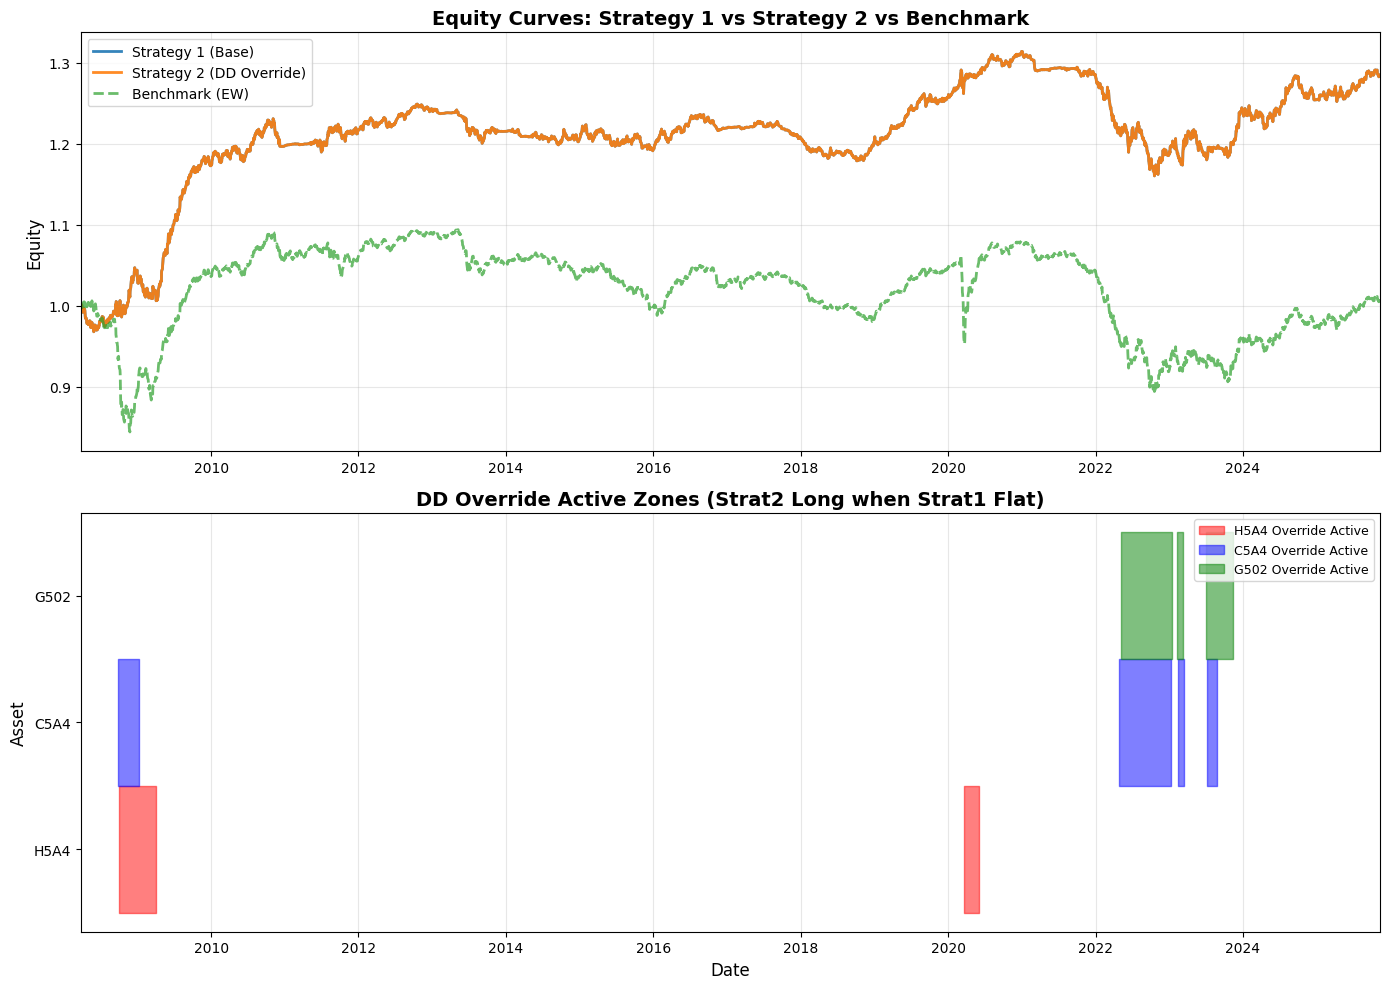

In [43]:
# =============================================================================
# EQUITY CURVE VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Panel 1: Equity Curves
ax = axes[0]
ax.plot(equity_strat1.index, equity_strat1, label='Strategy 1 (Base)', linewidth=2, alpha=0.9)
ax.plot(equity_strat2.index, equity_strat2, label='Strategy 2 (DD Override)', linewidth=2, alpha=0.9)
ax.plot(equity_benchmark.index, equity_benchmark, label='Benchmark (EW)', linewidth=2, alpha=0.7, linestyle='--')

ax.set_title('Equity Curves: Strategy 1 vs Strategy 2 vs Benchmark', fontsize=14, fontweight='bold')
ax.set_ylabel('Equity', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(data.index.min(), data.index.max())

# Panel 2: Signal Comparison (Strategy 1 vs Strategy 2)
ax = axes[1]
colors = {'H5A4': 'red', 'C5A4': 'blue', 'G502': 'green'}

for i, asset in enumerate(['H5A4', 'C5A4', 'G502']):
    # Plot where signals differ (Strat2 = 1, Strat1 = 0)
    override_active = ((signals_strat2[asset] == 1) & (signals_strat1[asset] == 0)).astype(int)
    
    ax.fill_between(data.index, 
                    override_active * (i + 1),
                    i,
                    where=(override_active > 0),
                    color=colors[asset], alpha=0.5, label=f'{asset} Override Active')

ax.set_title('DD Override Active Zones (Strat2 Long when Strat1 Flat)', fontsize=14, fontweight='bold')
ax.set_ylabel('Asset', fontsize=12)
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_yticklabels(['H5A4', 'C5A4', 'G502'])
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(data.index.min(), data.index.max())

plt.tight_layout()
plt.show()

---
## Turnover Analysis

In [28]:
# =============================================================================
# TURNOVER ANALYSIS
# =============================================================================

def analyze_turnover(weights, strategy_name):
    """Calculate turnover statistics for a strategy."""
    weight_changes = weights.diff().abs()
    daily_turnover = weight_changes.sum(axis=1)
    
    total_days = len(daily_turnover)
    years = total_days / 252
    
    stats = {
        'strategy': strategy_name,
        'total_turnover': daily_turnover.sum(),
        'annualized_turnover': daily_turnover.sum() / years,
        'mean_daily': daily_turnover.mean(),
        'max_daily': daily_turnover.max(),
        'days_gt_1pct': (daily_turnover > 0.01).sum(),
        'trading_days': (daily_turnover > 0.001).sum()
    }
    
    return stats, daily_turnover

# Analyze both strategies
stats_s1, turnover_s1 = analyze_turnover(weights_strat1, 'Strategy 1')
stats_s2, turnover_s2 = analyze_turnover(weights_strat2, 'Strategy 2')

print("\nTURNOVER COMPARISON")
print("=" * 80)
print(f"{'Metric':<30} {'Strategy 1':>20} {'Strategy 2':>20}")
print("-" * 80)
print(f"{'Total Turnover':<30} {stats_s1['total_turnover']:>19.2f}x {stats_s2['total_turnover']:>19.2f}x")
print(f"{'Annualized Turnover':<30} {stats_s1['annualized_turnover']:>19.2f}x {stats_s2['annualized_turnover']:>19.2f}x")
print(f"{'Mean Daily Turnover':<30} {stats_s1['mean_daily']*100:>18.2f}% {stats_s2['mean_daily']*100:>18.2f}%")
print(f"{'Max Daily Turnover':<30} {stats_s1['max_daily']*100:>18.2f}% {stats_s2['max_daily']*100:>18.2f}%")
print(f"{'Days with >1% Turnover':<30} {stats_s1['days_gt_1pct']:>20} {stats_s2['days_gt_1pct']:>20}")
print(f"{'Total Trading Days':<30} {stats_s1['trading_days']:>20} {stats_s2['trading_days']:>20}")
print("=" * 80)


TURNOVER COMPARISON
Metric                                   Strategy 1           Strategy 2
--------------------------------------------------------------------------------
Total Turnover                              335.13x              335.13x
Annualized Turnover                          19.03x               19.03x
Mean Daily Turnover                          7.55%               7.55%
Max Daily Turnover                         190.00%             190.00%
Days with >1% Turnover                         1486                 1486
Total Trading Days                             1711                 1711


In [29]:
# =============================================================================
# TRADE-BY-TRADE LOG (Strategy 1)
# =============================================================================

TRADE_THRESHOLD = 0.01  # 1% turnover = significant trade

def generate_trade_log(weights, signals, daily_turnover, data, strategy_name):
    """Generate detailed trade log."""
    trade_days = daily_turnover[daily_turnover > TRADE_THRESHOLD]
    
    print(f"\n{'='*100}")
    print(f"TRADE LOG - {strategy_name}")
    print(f"{'='*100}")
    print(f"Trade Definition: Daily turnover > {TRADE_THRESHOLD*100:.1f}%")
    print(f"Total Trades: {len(trade_days)}")
    
    trade_log = []
    cumulative_to = 0
    
    for i, (date, turnover) in enumerate(trade_days.items()):
        cumulative_to += turnover
        date_idx = weights.index.get_loc(date)
        prev_date = weights.index[date_idx - 1] if date_idx > 0 else None
        
        curr_weights = weights.loc[date]
        prev_weights = weights.loc[prev_date] if prev_date else pd.Series({'Cash': 0.1, 'H5A4': 0, 'C5A4': 0, 'G502': 0.9})
        
        
        curr_signals = {asset: signals.loc[date, asset] for asset in ['H5A4', 'C5A4', 'G502']}
        
        trade_log.append({
            'Trade #': i + 1,
            'Date': date,
            'Turnover': turnover,
            'Cumulative': cumulative_to,
            'Cash': curr_weights['Cash'],
            'H5A4': curr_weights['H5A4'],
            'C5A4': curr_weights['C5A4'],
            'G502': curr_weights['G502'],
            'Signals': f"H:{int(curr_signals['H5A4'])} C:{int(curr_signals['C5A4'])} G:{int(curr_signals['G502'])}"
        })
    
    # Print trade log
    print(f"\n{'#':<4} {'Date':<12} {'Turnover':>10} {'Cumul':>8} | {'Cash':>8} {'H5A4':>8} {'C5A4':>8} {'G502':>8} | {'Signals':<14}")
    print("-" * 100)
    
    for t in trade_log:
        print(f"{t['Trade #']:<4} {t['Date'].strftime('%Y-%m-%d'):<12} "
              f"{t['Turnover']*100:>9.2f}% {t['Cumulative']:>7.2f}x | "
              f"{t['Cash']*100:>7.1f}% {t['H5A4']*100:>7.1f}% {t['C5A4']*100:>7.1f}% {t['G502']*100:>7.1f}% | "
              f"{t['Signals']:<14}")
    
    print("-" * 100)
    print(f"TOTAL: {len(trade_log)} trades, {cumulative_to:.2f}x cumulative turnover")
    
    return pd.DataFrame(trade_log)

# Generate trade logs
trade_log_s1 = generate_trade_log(weights_strat1, signals_strat1, turnover_s1, data, 'Strategy 1')


TRADE LOG - Strategy 1
Trade Definition: Daily turnover > 1.0%
Total Trades: 1486

#    Date           Turnover    Cumul |     Cash     H5A4     C5A4     G502 | Signals       
----------------------------------------------------------------------------------------------------
1    2008-03-26       10.00%    0.10x |     5.0%     0.0%     0.0%    95.0% | H:0 C:0 G:1   
2    2008-05-27       10.00%    0.20x |    10.0%     0.0%     0.0%    90.0% | H:0 C:0 G:1   
3    2008-06-03       10.00%    0.30x |     5.0%     0.0%     0.0%    95.0% | H:0 C:0 G:1   
4    2008-06-04       10.00%    0.40x |    10.0%     0.0%     0.0%    90.0% | H:0 C:0 G:1   
5    2008-06-06       24.00%    0.64x |     5.0%    12.0%     0.0%    83.0% | H:1 C:0 G:1   
6    2008-06-09      166.00%    2.30x |    88.0%    12.0%     0.0%     0.0% | H:1 C:0 G:1   
7    2008-06-10      180.00%    4.10x |    10.0%     0.0%     0.0%    90.0% | H:1 C:0 G:1   
8    2008-06-11      180.00%    5.90x |    88.0%    12.0%     0.0%     

In [30]:
# =============================================================================
# MONTHLY TRADING FREQUENCY
# =============================================================================

def analyze_monthly_frequency(trade_log_df, daily_turnover, strategy_name):
    """Analyze monthly trading frequency."""
    if len(trade_log_df) == 0:
        print(f"No trades to analyze for {strategy_name}")
        return None
    
    trade_log_df['YearMonth'] = trade_log_df['Date'].dt.to_period('M')
    monthly_trades = trade_log_df.groupby('YearMonth').agg({
        'Trade #': 'count',
        'Turnover': 'sum'
    }).rename(columns={'Trade #': 'Num_Trades', 'Turnover': 'Total_Turnover'})
    
    # All trading days (>0.1% turnover)
    all_trading = daily_turnover[daily_turnover > 0.001]
    all_trading_monthly = all_trading.groupby(all_trading.index.to_period('M')).count()
    monthly_trades['Trading_Days'] = all_trading_monthly
    monthly_trades = monthly_trades.fillna(0)
    
    print(f"\n{'='*80}")
    print(f"MONTHLY TRADING FREQUENCY - {strategy_name}")
    print(f"{'='*80}")
    print(f"\n{'Month':<10} {'Trades':>8} {'Trading Days':>14} {'Total Turnover':>16}")
    print("-" * 60)
    
    for month in monthly_trades.index:
        num_trades = int(monthly_trades.loc[month, 'Num_Trades'])
        trading_days = int(monthly_trades.loc[month, 'Trading_Days'])
        total_to = monthly_trades.loc[month, 'Total_Turnover']
        print(f"{str(month):<10} {num_trades:>8} {trading_days:>14} {total_to*100:>15.2f}%")
    
    print("-" * 60)
    print(f"\nSUMMARY:")
    print(f"  Average Trades per Month:       {monthly_trades['Num_Trades'].mean():.2f}")
    print(f"  Max Trades in a Month:          {monthly_trades['Num_Trades'].max():.0f}")
    print(f"  Average Trading Days per Month: {monthly_trades['Trading_Days'].mean():.2f}")
    print(f"  Max Trading Days in a Month:    {monthly_trades['Trading_Days'].max():.0f}")
    print(f"  Average Turnover per Month:     {monthly_trades['Total_Turnover'].mean()*100:.2f}%")
    print(f"  Max Turnover in a Month:        {monthly_trades['Total_Turnover'].max()*100:.2f}%")
    
    return monthly_trades

# Analyze monthly frequency for Strategy 1
monthly_s1 = analyze_monthly_frequency(trade_log_s1, turnover_s1, 'Strategy 1')


MONTHLY TRADING FREQUENCY - Strategy 1

Month        Trades   Trading Days   Total Turnover
------------------------------------------------------------
2008-03           1              1           10.00%
2008-05           1              1           10.00%
2008-06           7              7          750.00%
2008-08           4              4           40.00%
2008-09           1              1           10.00%
2009-01          10             12           91.91%
2009-02           3              3           16.97%
2009-03           7              7           70.00%
2009-04          12             12          563.23%
2009-11           3              4            5.48%
2009-12           1              1            1.19%
2010-05           7             10          112.41%
2010-06          20             22          204.02%
2010-07          18             21           73.92%
2010-08          16             20           47.01%
2010-09          15             21           45.21%
2010-10       

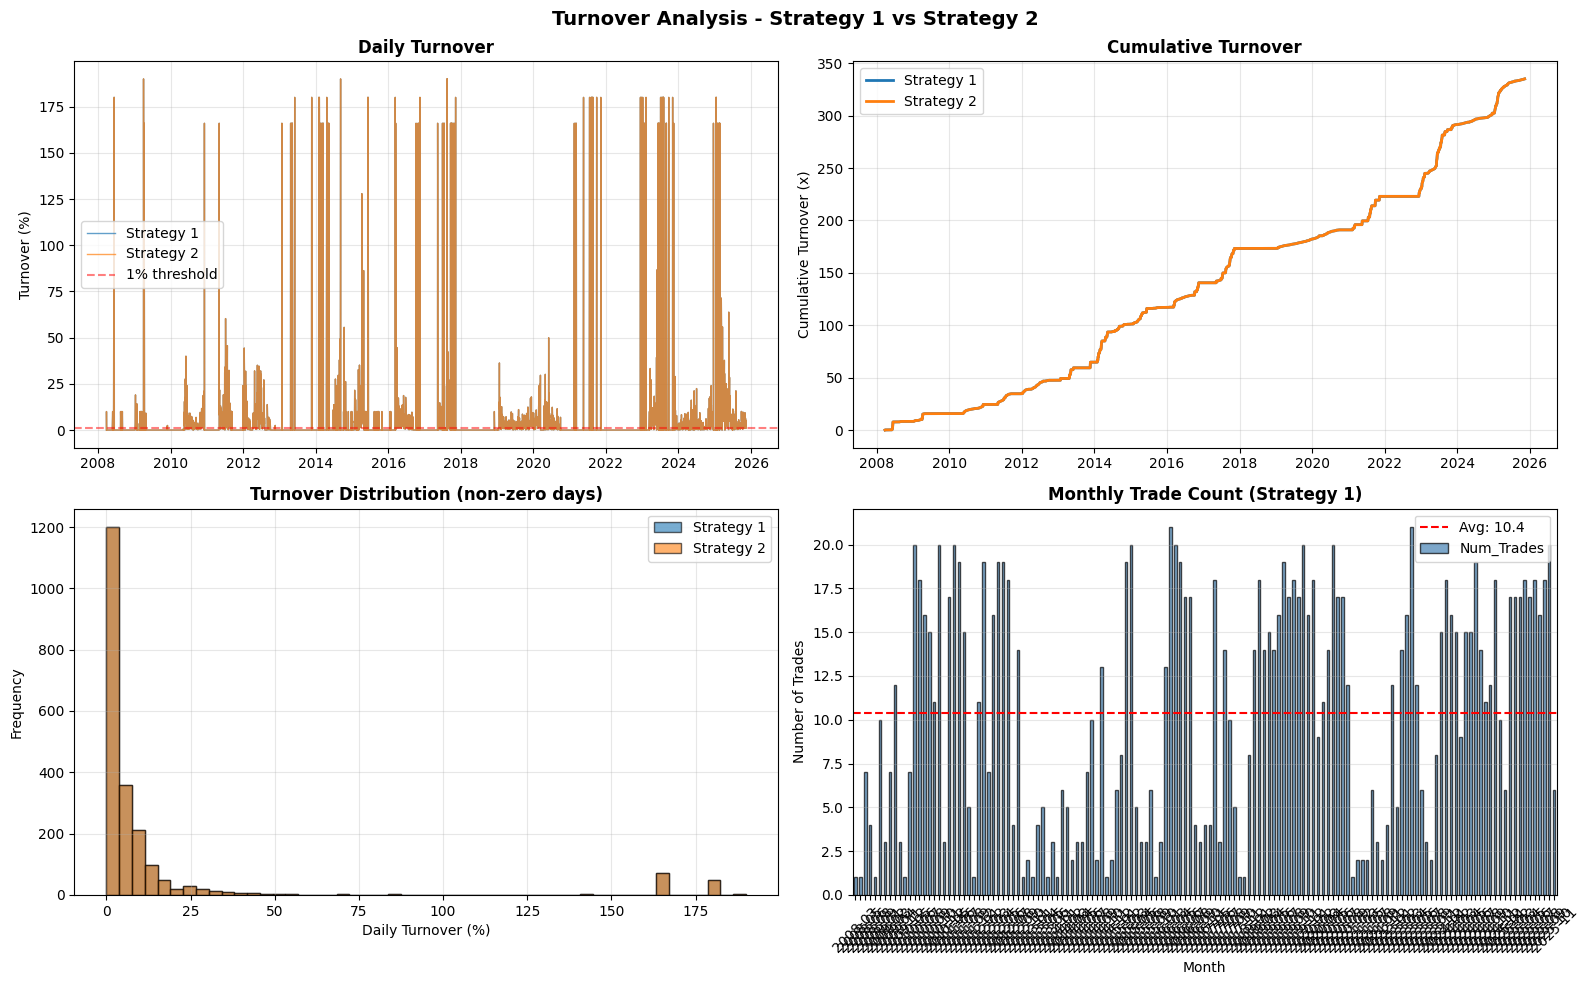

In [31]:
# =============================================================================
# TURNOVER VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Turnover Analysis - Strategy 1 vs Strategy 2', fontsize=14, fontweight='bold')

# Panel 1: Daily Turnover Comparison
ax = axes[0, 0]
ax.plot(turnover_s1.index, turnover_s1 * 100, alpha=0.7, label='Strategy 1', linewidth=1)
ax.plot(turnover_s2.index, turnover_s2 * 100, alpha=0.7, label='Strategy 2', linewidth=1)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='1% threshold')
ax.set_title('Daily Turnover', fontweight='bold')
ax.set_ylabel('Turnover (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Cumulative Turnover
ax = axes[0, 1]
ax.plot(turnover_s1.index, turnover_s1.cumsum(), label='Strategy 1', linewidth=2)
ax.plot(turnover_s2.index, turnover_s2.cumsum(), label='Strategy 2', linewidth=2)
ax.set_title('Cumulative Turnover', fontweight='bold')
ax.set_ylabel('Cumulative Turnover (x)')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Turnover Distribution
ax = axes[1, 0]
ax.hist(turnover_s1[turnover_s1 > 0] * 100, bins=50, alpha=0.6, label='Strategy 1', edgecolor='black')
ax.hist(turnover_s2[turnover_s2 > 0] * 100, bins=50, alpha=0.6, label='Strategy 2', edgecolor='black')
ax.set_title('Turnover Distribution (non-zero days)', fontweight='bold')
ax.set_xlabel('Daily Turnover (%)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Monthly Trades (Strategy 1)
ax = axes[1, 1]
if monthly_s1 is not None:
    monthly_s1['Num_Trades'].plot(kind='bar', ax=ax, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axhline(y=monthly_s1['Num_Trades'].mean(), color='red', linestyle='--', 
               label=f"Avg: {monthly_s1['Num_Trades'].mean():.1f}")
ax.set_title('Monthly Trade Count (Strategy 1)', fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Trades')
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## Summary

In [32]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "=" * 80)
print("REGENTFUND ALLOCATION STRATEGY - SUMMARY")
print("=" * 80)

print(f"\nData Period: {data.index.min().date()} to {data.index.max().date()} ({len(data):,} days)")

print(f"\nStrategy 1 (Base Proportional Linear):")
print(f"  Final Equity:     {equity_strat1.iloc[-1]:.4f}")
print(f"  Total Return:     {(equity_strat1.iloc[-1] - 1) * 100:.2f}%")
print(f"  Sharpe Ratio:     {metrics_df[metrics_df['Strategy']=='Strategy 1 (Base)']['Sharpe'].values[0]:.2f}")
print(f"  Max Drawdown:     {metrics_df[metrics_df['Strategy']=='Strategy 1 (Base)']['Max_DD'].values[0]:.2%}")
print(f"  Ann. Turnover:    {stats_s1['annualized_turnover']:.2f}x")

print(f"\nStrategy 2 (DD Override):")
print(f"  Final Equity:     {equity_strat2.iloc[-1]:.4f}")
print(f"  Total Return:     {(equity_strat2.iloc[-1] - 1) * 100:.2f}%")
print(f"  Sharpe Ratio:     {metrics_df[metrics_df['Strategy']=='Strategy 2 (DD Override)']['Sharpe'].values[0]:.2f}")
print(f"  Max Drawdown:     {metrics_df[metrics_df['Strategy']=='Strategy 2 (DD Override)']['Max_DD'].values[0]:.2%}")
print(f"  Ann. Turnover:    {stats_s2['annualized_turnover']:.2f}x")

# Calculate override days for each asset
override_days = {}
for asset in ['H5A4', 'C5A4', 'G502']:
    override_days[asset] = ((signals_strat2[asset] == 1) & (signals_strat1[asset] == 0)).sum()
print(f"  Override Days:    H5A4={override_days['H5A4']}, C5A4={override_days['C5A4']}, G502={override_days['G502']}")

print(f"\nBenchmark (Equal Weight):")
print(f"  Final Equity:     {equity_benchmark.iloc[-1]:.4f}")
print(f"  Total Return:     {(equity_benchmark.iloc[-1] - 1) * 100:.2f}%")

print("\n" + "=" * 80)


REGENTFUND ALLOCATION STRATEGY - SUMMARY

Data Period: 2008-03-25 to 2025-11-11 (4,439 days)

Strategy 1 (Base Proportional Linear):
  Final Equity:     1.2844
  Total Return:     28.44%
  Sharpe Ratio:     0.51
  Max Drawdown:     -11.71%
  Ann. Turnover:    19.03x

Strategy 2 (DD Override):
  Final Equity:     1.2844
  Total Return:     28.44%
  Sharpe Ratio:     0.51
  Max Drawdown:     -11.71%
  Ann. Turnover:    19.03x
  Override Days:    H5A4=178, C5A4=305, G502=291

Benchmark (Equal Weight):
  Final Equity:     1.0063
  Total Return:     0.63%

